# Mass--concentration relations from GMMs

To demonstrate the power of our approach, let's show how we can recreate mass--concentration relations from our GMMs. We will take from our catalogs measurements of the ($200m$ and NFW) concentration $c$ and peak height $\nu$ of a bunch of halos. We will model the distribution with a Gaussian mixture model (GMM), and demonstrate how conditional statistics can recover usual M-c relations (in this case $\nu$-c relations).

In [1]:
import ConditionalGMM
import itertools
import numpy as np
from scipy import linalg
from sklearn import mixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

%matplotlib inline

In [2]:
#Plotting format
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=20)

In [3]:
#Read in the pickled pandas dataframe
df = pd.read_pickle("./sparta_cats/L1000_N1024_CBol/df_L1000_sf1_CBol.pkl")
df2 = pd.read_pickle("./sparta_cats/L2000_N1024_CBol/df_L2000_sf1_CBol.pkl")
df3 = pd.read_pickle("./sparta_cats/L0500_N1024_CBol/df_L0500_sf1_CBol.pkl")

df = df.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
print(df.shape, df2.shape, df3.shape)
print(df.shape)
print(df.X_Rsp_mean.shape)

(124742, 119) (7950, 119) (70319, 119)
(124742, 119)
(124742,)


Text(0, 0.5, 'log concentration')

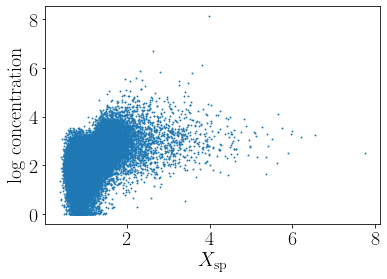

In [4]:
c = df.c200b
nu = df.nu200b
Xsp = df.X_Rsp_mean
#plt.scatter(np.log(nu), np.log(c), 0.8)
plt.scatter(Xsp, np.log(c), 0.8)
#plt.xlim(1.7, 4.6)
plt.xlabel(r"$X_{\rm sp}$")
plt.ylabel(r"log concentration")
#plt.savefig("nu_c_scatter.png", dpi=300, bbox_inches="tight")

In [5]:
#Let's cut the crazy outlier with c~60 and with too-small concentrations (they don't make sense)
#Also cut out the very small peak heights
cut = np.where((c < 40) & (np.log(c) > 0.2) & (nu > 1.7) == True)[0]
nu = nu[cut]
c = c[cut]
Xsp = Xsp[cut]
X = np.array([Xsp, np.log(c)]).T
print(c.shape, nu.shape, X.shape)

(59093,) (59093,) (59093, 2)


(39592, 2) (19501, 2)
[-3486.58006391 -2338.06891727 -2604.22261078 -2511.98083024
 -2448.73083442 -2253.709399   -2247.2227731  -2248.58189167
 -2240.30921795 -2241.67292425 -2178.5822001  -2170.87664554
 -2255.96510502 -2192.53684783]


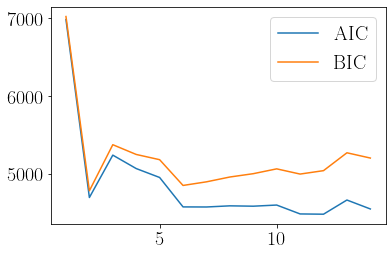

In [6]:
#Train a GMM - figure out how many components we need
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
n_components = np.arange(1, 14+1)
scores = np.zeros_like(n_components, dtype="float")
BIC = np.zeros_like(scores)
AIC = np.zeros_like(scores)
for i, n in enumerate(n_components):
    gmm = mixture.GaussianMixture(n_components=n, covariance_type='full').fit(X_train)
    scores[i] = gmm.score_samples(X_test).sum()
    BIC[i] = gmm.bic(X_test)
    AIC[i] = gmm.aic(X_test)
print(scores)
plt.plot(n_components, AIC, label="AIC")
plt.plot(n_components, BIC, label="BIC")
plt.legend()

In [7]:
#5 Components seems reasonable, since it satisfies the BIC
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
weights = gmm.weights_
means = gmm.means_
covs = gmm.covariances_
cGMM = ConditionalGMM.CondGMM(weights, means, covs, fixed_indices=[0])
print(weights)

[0.38488126 0.61511874]


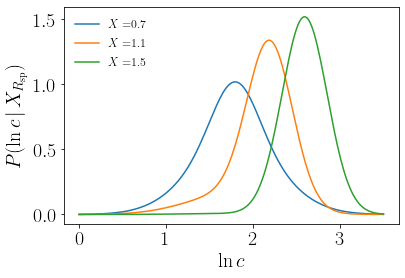

In [8]:
#colors = ["blue", "orange", "green"]

lnX_obs = np.linspace(0.7, 1.5, 3)
lnc = np.linspace(0, 3.5, 200)
for i, lnX in enumerate(lnX_obs):
    lnc_cpdf = np.array([cGMM.conditional_pdf([yi], lnX) for yi in lnc])
    plt.plot(lnc, lnc_cpdf, label=r"$X=${x:.1f}".format(x=lnX))#, color=colors[i])
plt.xlabel(r"$\ln c$")
plt.ylabel(r"$P(\ln c\,|\,X_{R_{\rm sp}})$")
plt.legend(frameon=False, fontsize=12)
plt.savefig("X_c_conditionals.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, '${\\rm E}[\\ln c|X_{R_{\\rm sp}}]$')

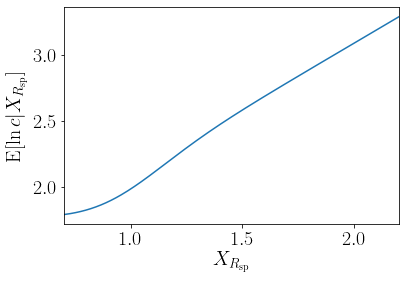

In [9]:
lnX_obs = np.linspace(0.7, 2.2, 200)
lnc_mean = np.zeros_like(lnX_obs)
for i, x in enumerate(lnX_obs):
    lnc_mean[i] = cGMM.conditional_mean([x])
plt.plot(lnX_obs, lnc_mean)
plt.xlim(min(lnX_obs), max(lnX_obs))
plt.xlabel(r"$X_{R_{\rm sp}}$")
plt.ylabel(r"${\rm E}[\ln c|X_{R_{\rm sp}}]$")